![logo](../../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Satellite-Derived Data Insights into Long-Term Lake Temperature Trends

Production date: 29-04-2025

Produced by: Amaya Camila Trigoso Barrientos (VUB)

## 🌍 Use case: Analyzing the long-term trend in surface water temperature of Lake Superior

## ❓ Quality assessment question(s)
* **Can satellite data be used to detect the observed increase in summer water temperatures in Lake Superior due to global warming?**

Cases of an increasing trend in lake surface water temperature (LSWT) have been observed in numerous lakes across various regions, including the United States, Europe, and other parts of the world [[1]](https://doi.org/10.1038/s41558-024-02122-y) [[2]](https://climate.copernicus.eu/lake-surface-temperatures). For example, Austin and Colman (2008) found that summer LSWT in Lake Superior increased at a rate of (11±6)×10<sup>-2</sup> °C/year from 1979 to 2006. They attributed this trend to the earlier retreat of winter ice, which causes the positive overturning period to begin sooner, allowing the lake more time to warm. Their analysis was based on measurements from in-situ buoys [[3]](https://doi.org/10.1029/2006GL029021). Later, the Great Lakes Integrated Sciences and Assessments (GLISA) analyzed the annual mean LSWT of Lake Superior between 1995 and 2021. The increasing long-term trend observed by Austin and Colman was not apparent in the period analyzed by GLISA. However, they noted a shift to higher temperatures after 1998 [4]. The LSWT data analyzed by GLISA was derived from satellite observations and obtained through the NOAA Great Lakes CoastWatch [[5]](https://coastwatch.glerl.noaa.gov/statistics/average-surface-water-temperature-glsea/).

The objective of this study is to evaluate whether the [satellite-lake-water-temperature](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview) dataset from the Climate Data Store (CDS) is suitable for climate change monitoring, using Lake Superior as a case study. We calculated the trend summer LWST for a period of 28 years, from 1995 to 2023.

## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
* Lake Superior's summer LSWT trend from 1995 to 2023 shows a slightly negative slope, though this trend is not statistically significant. The mean summer temperature during this period was 14.1 °C.
* The [satellite-lake-water-temperature](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-temperature?tab=overview) dataset and NOAA’s satellite-derived LSWT data are very similar overall. However, during colder years, NOAA’s LSWT values tend to be lower, possibly due to cloud contamination.
* This dataset is valuable for climate change monitoring. However, complementing it with in situ data from years prior to 1995, if available, could provide a more comprehensive understanding of long-term trends.
```

## 📋 Methodology

The analysis and results are organized in the following steps, which are detailed in the sections below:

**[](satellite_satellite-lake-water-temperature_validation_q02:section-1)**
 * Download satellite water temperature data for the summer months (July, August, September) from 1995 to 2023.

**[](satellite_satellite-lake-water-temperature_validation_q02:section-2)**
 * Filter the data by quality level and lake ID.
 * Calculate the spatial weighted mean of LSWT.

**[](satellite_satellite-lake-water-temperature_validation_q02:section-3)**
 * Calculate the yearly summer mean of LSWT.
 * Perform linear regression.
 * Plot the results.
 * Discuss results.
 
**[](satellite_satellite-lake-water-temperature_validation_q02:section-4)** 
 * Load the NOAA dataset.
 * Plot both datasets over time.
 * Calculate Mean Bias, Mean Absolute Error (MAE), Root Mean Square Error (RMSE).
 * Plot Residuals (CDS-NOAA) and plot a map of outlier value.
 * Discuss results.

## 📈 Analysis and results

(satellite_satellite-lake-water-temperature_validation_q02:section-1)=
### 1. Request and download data

#### Import packages

In [1]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.cbook
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
from scipy.stats import linregress
from matplotlib.lines import Line2D
plt.style.use("seaborn-v0_8-notebook")

#### Set variables

In [2]:
# Time
year_start = 1995
year_stop = 2023

# Region
lon_slice = slice(-92.10, -84.80)
lat_slice = slice(46.30, 49.00)

# Variable
varname = "lake_surface_water_temperature"

#### Set the data request

In [3]:
collection_id = "satellite-lake-water-temperature"
requests = []
for year in range(year_start, year_stop + 1):
    requests.append(
        {
            "variable": "all",
            "year": [str(year)],
            "month": ["07", "08", "09"],
            "day": [f"{day:02d}" for day in range(1, 32)],
            "version": ["4_5" if year < 2021 else "4_5_2"],
        }
    )

#### Download data

In [4]:
ds = download.download_and_transform(
    collection_id,
    requests,
    transform_func=utils.regionalise,
    transform_func_kwargs={"lon_slice": lon_slice, "lat_slice": lat_slice},
    chunks={"year": 1},
)

100%|██████████| 29/29 [00:16<00:00,  1.71it/s]


(satellite_satellite-lake-water-temperature_validation_q02:section-2)=
### 2. Data preprocessing 

#### Plot lakeid

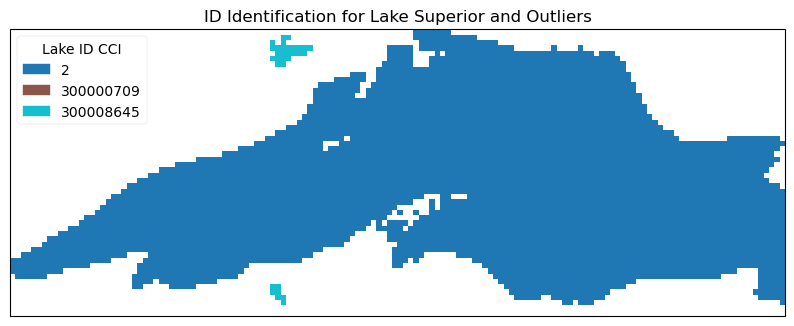

In [5]:
lakeid_data = ds['lakeid_CCI']
lats = ds['latitude']
lons = ds['longitude']

# Replace this with your actual unique IDs
unique_ids = np.unique(lakeid_data.values[~np.isnan(lakeid_data.values)])  # Exclude NaN values
cmap = plt.get_cmap('tab10', len(unique_ids))  # Use a discrete colormap

# Plot the map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
im = ax.pcolormesh(lons, lats, lakeid_data.isel(time=0), cmap=cmap, shading='auto')

# Create a custom legend
legend_handles = [
    mpatches.Patch(color=cmap(i / len(unique_ids)), label=f"{int(uid)}")
    for i, uid in enumerate(unique_ids)
]
ax.legend(
    handles=legend_handles,
    loc='upper left',  # Position the legend
    title='Lake ID CCI',
    frameon=True
)

ax.set_title('ID Identification for Lake Superior and Outliers')
# Save the plot as a file
plt.savefig("/data/wp5/trigoso_camila/LakeSurfaceTemperature/latest_submission/lakeID_lswt.png", dpi=200, bbox_inches="tight")  # Save as PNG

# Show the plot
plt.show()

```{figure} d7197153-082e-41a7-a8fc-0fdcfaa1c66f.png
---
name: fig-ids
figwidth: 80%
---
ID Identification for Lake Superior and Outliers. 
```

#### Data filtering

It can be observed that the lake ID of Lake Superior is 2, which is the lowest value when printing the values, and it is plotted in purple.
Regarding the quality level. We will only use these levels:
- 4: good quality
- 5: best quality

In [6]:
# Reindex using lakeids and min_quality_level
lakeid = (
    xr.DataArray(np.unique(ds["lakeid_CCI"].values), dims=("lakeid_CCI"))
    .dropna("lakeid_CCI")
    .astype(int)
)
min_quality_level = xr.DataArray([0, 4], dims=("min_quality_level"))
ds = ds.drop_vars("lakeid_CCI").where(ds["lakeid_CCI"] == lakeid)
ds = ds.where(ds["lswt_quality_level"] >= min_quality_level)
ds = ds.assign_coords(lakeid_CCI=lakeid, min_quality_level=min_quality_level)

filtered_ds = ds.sel(lakeid_CCI=2, min_quality_level=4)

#### Spatial weighted mean

In [7]:
# Spatial weighted mean
da = diagnostics.spatial_weighted_mean(filtered_ds[varname])

(satellite_satellite-lake-water-temperature_validation_q02:section-3)=
### 3. Summer mean analisys
#### Summer mean and standard deviation

In [8]:
#Convert to °C
daC = da - 273.15 #We convert to °C for comparison with Austin & Colman (2007)
#Calculate the mean
summer_yearly_mean = daC.groupby('time.year').mean(dim='time')
#Calculate the standard deviation
summer_yearly_std_dev = daC.groupby('time.year').std(dim='time')

#### Perform linear regression for the full set (1995-2023)

In [9]:
# Define the years for the full dataset and subset
years_full = summer_yearly_mean['year'].values

# Perform linear regression on the full dataset
slope_full, intercept_full, r_value, p_value, std_err = linregress(years_full, summer_yearly_mean.values)
trend_full = slope_full * years_full + intercept_full

# Print the linear regression equation in a readable format
print(f"The equation of the trend line is: \ny = {slope_full:.4f} °C/year * x + {intercept_full:.4f} °C")
# Printing the results
print("\nSlope of the trend line:", round(slope_full,4),"°C/year")
print("Intercept of the trend line:", round(intercept_full,4),"°C")
print("Correlation coefficient (R value):", round(r_value,4))
print("P-value of the regression:", round(p_value,4))
print("Standard error of the slope:", round(std_err,4),"°C/year")

The equation of the trend line is: 
y = -0.0133 °C/year * x + 40.7965 °C

Slope of the trend line: -0.0133 °C/year
Intercept of the trend line: 40.7965 °C
Correlation coefficient (R value): -0.0887
P-value of the regression: 0.6472
Standard error of the slope: 0.0287 °C/year


#### Plot results

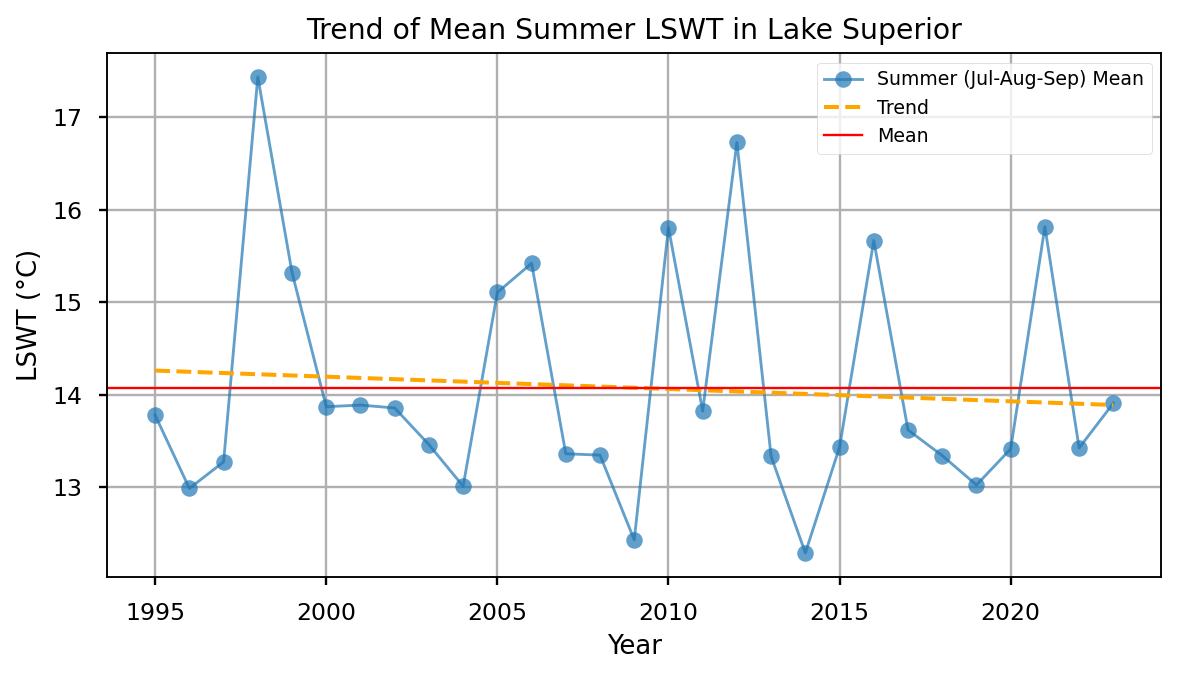

In [10]:
# Plot both the original data and the trend lines
plt.figure(figsize=(8,4), dpi=170)

#Plot yearly mean
plt.plot(years_full, summer_yearly_mean, label="Summer (Jul-Aug-Sep) Mean", marker="o", linewidth=1.2, alpha=0.7)

# Plot the trend lines
plt.plot(years_full, trend_full, label="Trend", color="orange",  linestyle="--", linewidth=1.7)
mean_all=summer_yearly_mean.mean(dim='year').values.item()
plt.axhline(y=mean_all, color='red', linestyle='-', label='Mean',linewidth=1)

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("LSWT (°C)")  # Adjust units if necessary
plt.title("Trend of Mean Summer LSWT in Lake Superior")
plt.legend(fontsize=8) 
plt.grid(True)

# Save the plot as a file
plt.savefig("/data/wp5/trigoso_camila/LakeSurfaceTemperature/latest_submission/trend_lswt.png", dpi=200, bbox_inches="tight")  # Save as PNG

plt.show()

```{figure} f6752a95-e0ee-4c9f-8f92-7cc92126ba79.png
---
name: fig-trend
figwidth: 100%
---
Mean Summer LSWT and Trend for the period 1995 - 2023 using the CDS dataset. 
```

#### Discussion
The trend line in {ref}`fig-trend` has a negative slope of -0.0133 °C/yr. However, the standard error of the slope is 0.0287 °C/year, which is relatively large compared to the slope itself, indicating low confidence in this trend. Additionally, the p-value of 0.6472 is substantially higher than the commonly used significance threshold of 0.05. This high p-value suggests that the trend is not statistically significant. The absence of significance could be partly due to the relatively short period of 28 years analyzed in this study, as longer time series are often needed to detect meaningful climate trends in such large water bodies.

The findings from Austin and Colman (2008) [[3]](https://doi.org/10.1029/2006GL029021) provide additional context to the LSWT trends in Lake Superior. Their analysis, which included in situ buoy measurements, showed an increasing trend in lake surface temperature during the 1980s and 1990s. This warming period may have led to elevated temperature levels that persisted in the following decades. Although the current analysis from 1995 to 2023 does not reveal a statistically significant trend, Austin and Colman's findings suggest that earlier warming could have established a higher baseline, potentially masking any recent, subtle changes in LSWT.

(satellite_satellite-lake-water-temperature_validation_q02:section-4)=
### 4. Comparison to NOAA Great Lakes CoastWatch data

#### Load the NOAA dataset

In [11]:
#NOAA data
df_noaa = pd.read_csv("/data/wp5/trigoso_camila/LakeSurfaceTemperature/latest_submission/lake_superior.csv") 

# Filter the dataframe to only keep rows where the month is July, August, or September
summer_df = df_noaa[df_noaa['Month'].isin([7, 8, 9])]

# Group by year and calculate the mean of the 'Sup.' column for each year
summer_mean = summer_df.groupby('Year')['Sup.'].mean().reset_index()

# Rename the columns for clarity (optional)
summer_mean.columns = ['Year', 'Summer_Mean_Sup']

The CSV file contains the mean daily temperature for every day from 1995 to 2023. This data was obtained from the NOAA Great Lakes CoastWatch webpage [[5]](https://coastwatch.glerl.noaa.gov/statistics/average-surface-water-temperature-glsea/) under the section "Average GLSEA Surface Water Temperature Data (by year)". 

The NOAA CoastWatch Great Lakes Regional Node dataset provides lake surface water temperature (LSWT) data derived from multiple sources, including the NOAA Advanced Very High Resolution Radiometer (AVHRR), the Visible Infrared Imaging Radiometer Suite on the Suomi National Polar-Orbiting Partnership spacecraft (VIIRS S-NPP), and the VIIRS instrument on NOAA-20 [[6]](https://coastwatch.glerl.noaa.gov/satellite-data-products/lake-surface-temperature/?lk=g&yr=2021). 

#### Plot both datasets over time

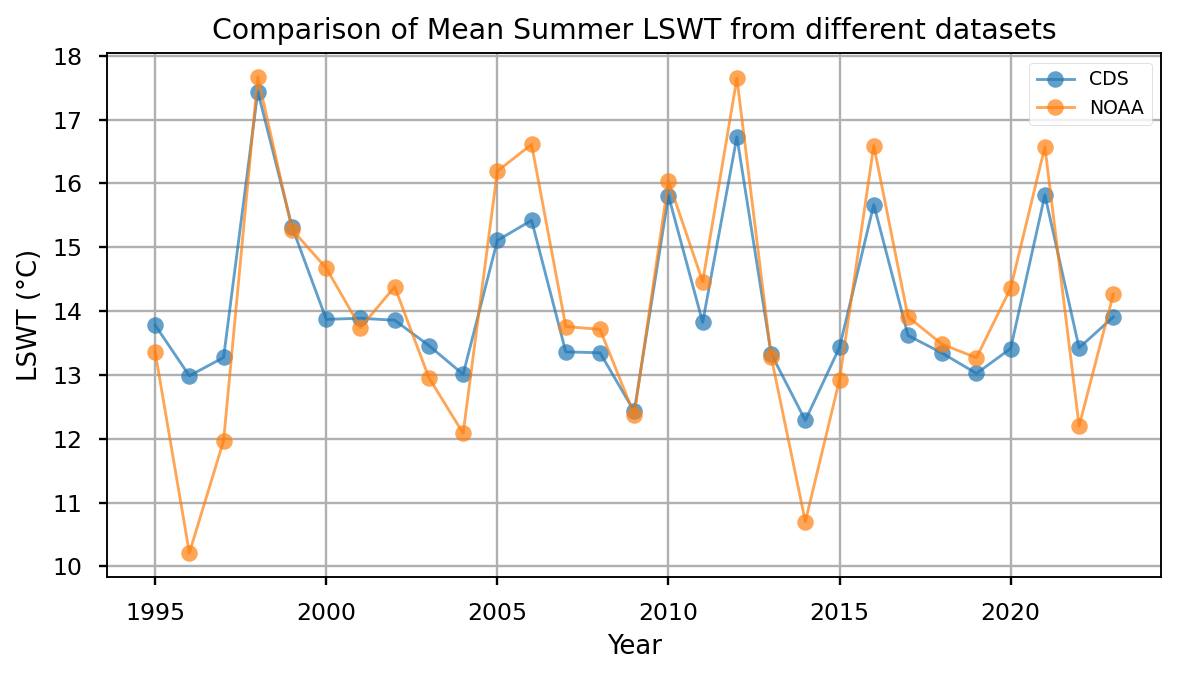

In [12]:
# Plot both the original data and the trend lines
plt.figure(figsize=(8,4), dpi=170)

#Plot summer mean CDS
plt.plot(years_full, summer_yearly_mean, label="CDS", marker="o", linewidth=1.2, alpha=0.7)

#Plot summer mean NOAA
plt.plot(years_full, summer_mean['Summer_Mean_Sup'], label="NOAA", marker="o", linewidth=1.2, alpha=0.7, )

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("LSWT (°C)")  # Adjust units if necessary
plt.title("Comparison of Mean Summer LSWT from different datasets", fontsize=12)
plt.legend(fontsize=8) 
plt.grid(True)

# Save the plot as a file
plt.savefig("/data/wp5/trigoso_camila/LakeSurfaceTemperature/latest_submission/fig_NOAA.png", dpi=200, bbox_inches="tight")  # Save as PNG

plt.show()

```{figure} 39459e06-5043-4a5e-980e-656a549de12b.png
---
name: fig-cds-noaa-vs-time
figwidth: 100%
---
Comparison of mean Summer LSWT and Trend for the period 1995 - 2023 using two different datasets, CDS and NOAA. 
```

#### Metrics calculation

In [13]:
cds_data = np.array(summer_yearly_mean.values.tolist())
noaa_data = np.array(summer_mean['Summer_Mean_Sup'].values.tolist())
years = np.arange(1995, 1995 + len(cds_data)).tolist()

# Calculate residuals and other metrics
mean_temp = (cds_data + noaa_data) / 2
residuals = cds_data - noaa_data
absolute_diff = np.abs(residuals)
mean_bias = np.mean(residuals)
mae = np.mean(absolute_diff)
rmse = np.sqrt(np.mean(residuals**2))

# Summary statistics
summary = pd.DataFrame({
    "Metric": ["Mean Bias", "Mean Absolute Error (MAE)", "Root Mean Square Error (RMSE)"],
    "Value (°C)": [mean_bias, mae, rmse]
})
summary

,Metric,Value (°C)
0,Mean Bias,-0.017580
1,Mean Absolute Error (MAE),0.674757
2,Root Mean Square Error (RMSE),0.885780


#### Residual Plot

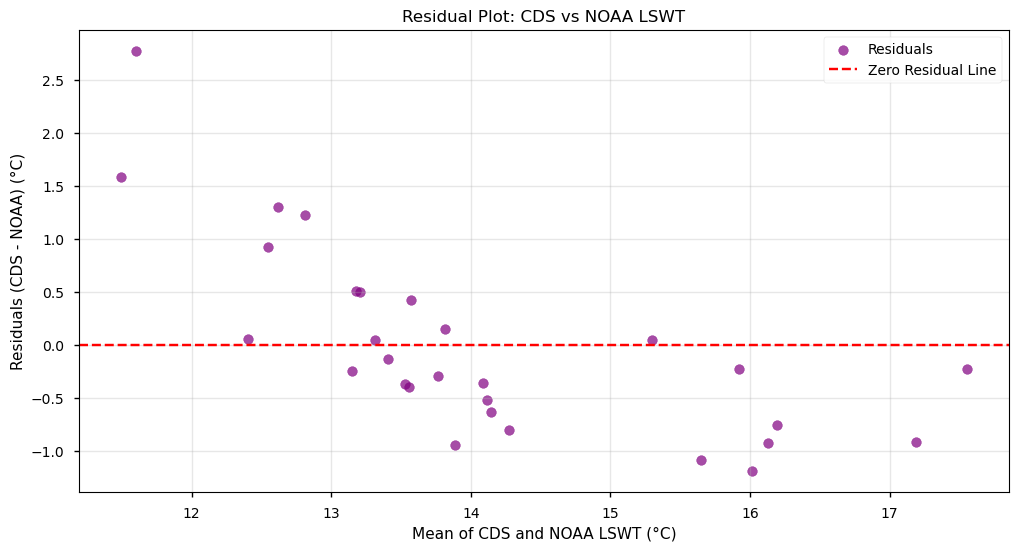

In [14]:
# Residual plot
plt.figure(figsize=(12, 6))
plt.scatter(mean_temp, residuals, color='purple', label='Residuals', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.xlabel('Mean of CDS and NOAA LSWT (°C)')
plt.ylabel('Residuals (CDS - NOAA) (°C)')
plt.title('Residual Plot: CDS vs NOAA LSWT')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("/data/wp5/trigoso_camila/LakeSurfaceTemperature/latest_submission/residual_plot.png", dpi=200, bbox_inches="tight")  # Save as PNG
plt.show()

```{figure} 00628707-395e-485b-b851-a75162154d53.png
---
name: fig-residuals
figwidth: 100%
---
Residual plot of CDS - NOAA LWST.
```

#### Map of mean summer LSWT for outlier value

In [15]:
#Convert to °C
dsC = filtered_ds[varname] - 273.15 #We convert to °C for comparison with Austin & Colman (2007)
#Calculate the mean
dsy = dsC.groupby('time.year').mean(dim='time')
dsy96 = dsy.sel(year=1996)

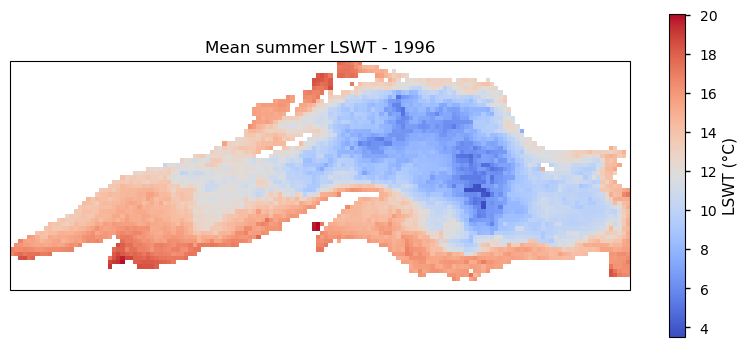

In [16]:
# Create a figure and a map projection
fig, ax = plt.subplots(
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(10, 6)
)

# Plot the data
data_plot = ax.pcolormesh(
    dsy96['longitude'], 
    dsy96['latitude'], 
    dsy96, 
    transform=ccrs.PlateCarree(), 
    cmap='coolwarm'  # Adjust colormap as needed
)

# Add a color bar
cbar = plt.colorbar(data_plot, ax=ax, orientation='vertical', shrink=0.7, label='LSWT (°C)')

# Add title and labels
ax.set_title("Mean summer LSWT - 1996")
# Save the plot as a file
plt.savefig("/data/wp5/trigoso_camila/LakeSurfaceTemperature/latest_submission/lswt96.png", dpi=200, bbox_inches="tight")  # Save as PNG
# Show the plot
plt.show()

```{figure} 551a0382-01d5-4966-a95f-caca7f7ea551.png
---
name: fig-lswt96
figwidth: 80%
---
Mean summer LWST of Lake Superior for the year 1996 .
```

#### Discussion
The CDS and NOAA values plotted in {numref}`fig-cds-noaa-vs-time`, along with the calculated comparison metrics, show that the mean summer LSWT values are mostly similar between the two datasets, with notable exceptions during colder years. The residuals plot in {numref}`fig-residuals` reveals that the largest differences occur at the two lowest temperatures. From {numref}`fig-cds-noaa-vs-time`, we observe that the greatest discrepancy occurred in 1997, where the NOAA dataset recorded a significantly lower temperature compared to the CDS dataset.

One possible explanation for this discrepancy is that the NOAA dataset may not filter out cloud contamination as effectively as the CDS dataset. This could result in artificially lower temperatures, as the NOAA data may be influenced by the temperature of cloud tops instead of the water surface.

To address whether the filtering applied in the CDS data introduced empty cells, we plotted a map of the summer mean LSWT for 1996 in {numref}`fig-lswt96`. The map revealed that only a few pixels were missing, indicating that the lake is largely complete with minimal data gaps.

## ℹ️ If you want to know more

* Farina, G., Thiem, H. (2024) [Several Great Lakes experience record-warm water temperatures heading into winter](https://www.climate.gov/news-features/event-tracker/several-great-lakes-experience-record-warm-water-temperatures-heading#). Climate.gov

### Key resources

Dataset documentation:
* [LSWT v4.5: Product User Guide and Specification (PUGS)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=348800177)

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [B-Open](https://www.bopen.eu/)

### References

List the references used in the Notebook here.


* [[1]](https://doi.org/10.1038/s41558-024-02122-y) Wang, X., Shi, K., Qin, B. et al. (2024). Disproportionate impact of atmospheric heat events on lake surface water temperature increases. Nat. Clim. Chang.
* [[2]](https://climate.copernicus.eu/lake-surface-temperatures) Copernicus (2018). Lake surface temperatures. Climate Change Service.
* [[3]](https://doi.org/10.1029/2006GL029021) Jay A. Austin, Steven M. Colman (2007). Lake Superior summer water temperatures are increasing more rapidly than regional air temperatures: A positive ice-albedo feedback. Geophysical Research LettersVolume 34, Issue 6. 
* [[4]](https://glisa.umich.edu/lake-superior-retrospective/) GLISA (2024). Lake Superior Retrospective.
* [[5]](https://coastwatch.glerl.noaa.gov/statistics/average-surface-water-temperature-glsea/) NOAA CoastWatch Great Lakes Regional Node (2024). Average Surface Water Temperature (GLSEA).
* [[6]](https://coastwatch.glerl.noaa.gov/satellite-data-products/lake-surface-temperature/?lk=g&yr=2021) NOAA CoastWatch Great Lakes Regional Node (2024). Lake Surface Temperature.